In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
from sklearn.model_selection import train_test_split 
import random
import itertools 
from tqdm import tqdm
import os
import time
from tensorboardX import SummaryWriter
import cv2 as cv
from torch.distributions.exponential import Exponential
from torch import nn, sin, pow
from torch.nn import Parameter

###  defines all potentials classes

In [2]:
def g(a):
    """Gaussian function

    :param a: float, real value
    :return: float, g(a)
    """
    return np.exp(- a ** 2)

class TripleWellPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta, *argv):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, array of position vectors (x,y), ndim = 2, shape = (,2)
        :return: V: np.array, array of potential energy values
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 2)
        assert(X.shape[1] == 2)
        x = X[:,0]
        y = X[:,1]
        u = g(x) * (g(y - 1/3) - g(y - 5/3))
        v = g(y) * (g(x - 1) + g(x + 1))
        V = 3 * u - 5 * v + 0.2 * (x ** 4) + 0.2 * ((y - 1/3) ** 4)
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """
        u = g(x) * (g(y - 1/3) - g(y - 5/3))
        a = g(y) * ((x - 1)*g(x - 1) + (x + 1) * g(x + 1))
        dVx = -6 * x * u + 10 * a + 0.8 * (x ** 3)
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        u = g(x) * ((y - 1/3) * g(y - 1/3) - (y - 5/3) * g(y - 5/3))
        b = g(y) * (g(x - 1) + g(x + 1))
        dVy = -6 * u + 10 * y * b + 0.8 * ((y - 1/3) ** 3)
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, array of position vectors (x,y), ndim = 2, shape = (,2)
        :return: grad(X): np.array, array of gradients with respect to position vector (x,y), ndim = 2, shape = (,2)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 2)
        assert(X.shape[1] == 2)
        return np.column_stack( (self.dV_x(X[:,0], X[:,1]), self.dV_y(X[:,0], X[:,1])) )
        
class TripleWellOneChannelPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta, *argv):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, array of position vectors (x,y), ndim = 2, shape = (,2)
        :return: V: np.array, array of potential energy values
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 2)
        assert(X.shape[1] == 2)   

        a = + 10 * np.exp(- 25 * X[:,0] ** 2 - (X[:,1] + (1 / 3)) ** 2)
        b = - 3 * np.exp(- X[:,0] ** 2 - (X[:,1] - (5 / 3)) ** 2)
        c = - 5 * np.exp(- X[:,1] ** 2 - (X[:,0] - 1) ** 2)
        d = - 5 * np.exp(- X[:,1] ** 2 - (X[:,0] + 1) ** 2) 
        e = + 0.2 * X[:,0] ** 4 + 0.2 * (X[:,1] - (1 / 3)) ** 4
        V = a + b + c + d + e 
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """
        a = - 20 * 25 * x * np.exp(- 25 * x ** 2 - (y + (1 / 3)) ** 2)
        b = + 6 * x * np.exp(- x ** 2 - (y - (5 / 3)) ** 2)
        c = + 10 * (x - 1) * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * (x + 1) * np.exp(- y ** 2 - (x + 1) ** 2) 
        e = + 0.8 * x ** 3
        dVx = a + b + c + d + e
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        a = - 20 * (y + (1 / 3)) * np.exp(- 25 * x ** 2 - (y + (1 / 3)) ** 2)
        b = + 6 * (y - (5 / 3)) * np.exp(- x ** 2 - (y - (5 / 3)) ** 2)
        c = + 10 * y * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * y * np.exp(- y ** 2 - (x + 1) ** 2) 
        e = + 0.8 * y ** 3
        dVy = a + b + c + d + e
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, array of position vectors (x,y), ndim = 2, shape = (,2)
        :return: grad(X): np.array, array of gradients with respect to position vector (x,y), ndim = 2, shape = (,2)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 2)
        assert(X.shape[1] == 2)
        return np.column_stack( (self.dV_x(X[:,0], X[:,1]), self.dV_y(X[:,0], X[:,1])) )
        
class DoubleWellPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta, *argv):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        """
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, array of position vectors (x,y), ndim = 2, shape = (,2)
        :return: V: np.array, array of potential energy values
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 2)
        assert(X.shape[1] == 2)
        a = 3 * np.exp(- X[:,0] ** 2 - X[:,1] ** 2)
        b = - 5 * np.exp(- X[:,1] ** 2 - (X[:,0] - 1) ** 2)
        c = - 5 * np.exp(- X[:,1] ** 2 - (X[:,0] + 1) ** 2)
        d = + 0.2 * X[:,0] ** 4 + 0.2 * X[:,1] ** 4
        V = a + b + c + d
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """   
        a = -6 * x * np.exp(- x ** 2 - y ** 2)
        b = + 10 * (x - 1) * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * (x + 1) * np.exp(- y ** 2 - (x + 1) ** 2)
        c = + 0.8 * x ** 3
        dVx = a + b + c + d
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        a = - 6 * y * np.exp(- x ** 2 - y ** 2) 
        b = + 10 * y * np.exp(- y ** 2 - (x - 1) ** 2)
        c = + 10 * y * np.exp(- y ** 2 - (x + 1) ** 2)
        d = + 0.8 * y ** 3
        dVy = a + b + c + d
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, array of position vectors (x,y), ndim = 2, shape = (,2)
        :return: grad(X): np.array, array of gradients with respect to position vector (x,y), ndim = 2, shape = (,2)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 2)
        assert(X.shape[1] == 2)
        return np.column_stack( (self.dV_x(X[:,0], X[:,1]), self.dV_y(X[:,0], X[:,1])) )
               
class TripleWellPotAlongCircle :
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
      # angle in [-pi, pi] 

      theta = np.arctan2(x[:,1], x[:,0])
      # radius
      r = np.sqrt( x[:,0] * x[:,0] + x[:,1] * x[:,1] )

      v_vec = np.zeros(len(x))
      for idx in range(len(x)) :
          # potential V_1
          if theta[idx] > math.pi / 3 : 
            v_vec[idx] = (1-(theta[idx] * 3 / math.pi- 1.0)**2)**2
          if theta[idx] < - math.pi / 3 : 
            v_vec[idx] = (1-(theta[idx] * 3 / math.pi + 1.0)**2)**2
          if theta[idx] > - math.pi / 3 and theta[idx] < math.pi / 3:
            v_vec[idx] = 3.0 / 5.0 - 2.0 / 5.0 * np.cos(3 * theta[idx])  
      # potential V_2
      v_vec = v_vec * 1.0 + (r - 1)**2 * 1.0 / self.eps + 5.0 * np.exp(-5.0 * r**2) 
      return v_vec

    def nabla_V(self, x): 
      # angle
      theta = np.arctan2(x[:,1], x[:,0])
      # radius
      r = np.sqrt( x[:,0] * x[:,0] + x[:,1] * x[:,1] )

      if any(np.fabs(r) < 1e-8): 
          print ("warning: radius is too small! r=%.4e" % r)
      dv1_dangle = np.zeros(len(x))
      # derivative of V_1 w.r.t. angle
      for idx in range(len(x)) :
          if theta[idx] > math.pi / 3: 
            dv1_dangle[idx] = 12 / math.pi * (theta[idx] * 3 / math.pi - 1) * ((theta[idx] * 3 / math.pi- 1.0)**2-1)
          if theta[idx] < - math.pi / 3: 
            dv1_dangle[idx] = 12 / math.pi * (theta[idx] * 3 / math.pi + 1) * ((theta[idx] * 3 / math.pi + 1.0)**2-1)
          if theta[idx] > -math.pi / 3 and theta[idx] < math.pi / 3:
            dv1_dangle[idx] = 1.2 * math.sin (3 * theta[idx])
      # derivative of V_2 w.r.t. angle
      dv2_dangle = np.zeros(len(x))
      # derivative of V_2 w.r.t. radius
      dv2_dr = 2.0 * (r-1.0) / self.eps - 50.0 * r * np.exp(-r**2/0.2)

      return np.column_stack((-(dv1_dangle + dv2_dangle) * x[:,1] / (r * r)+ dv2_dr * x[:,0] / r,  (dv1_dangle + dv2_dangle) * x[:,0] / (r * r)+ dv2_dr * x[:,1] / r))

class StiffPot : 
    """Class to gather methods related to the potential function"""
    def __init__(self, beta, eps):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
      return (x[:,0]**2 - 1)**2 + 1.0 / self.eps * (x[:,0]**2 + x[:,1] - 1)**2

    def nabla_V(self, x): 
      return np.column_stack(( 4.0 * x[:,0] * (x[:,0]**2 - 1.0 + 1.0 / self.eps * (x[:,0]**2 + x[:,1] - 1)), 2.0 / self.eps * (x[:,0]**2 + x[:,1] - 1)) )

class UniformPotAlongCircle :
    """Class to gather methods related to the potential function"""
    def __init__(self, beta, eps):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
      return 1.0 / self.eps * (x[:,0]**2 + x[:,1]**2 - 1)**2

    def nabla_V(self, x): 
      return np.column_stack( (4.0 * x[:,0] / self.eps * (x[:,0]**2 + x[:,1]**2 - 1), 4.0 * x[:,1] / self.eps * (x[:,0]**2 + x[:,1]**2 - 1)) )

class DoubleWellPotAlongCircle :
    """Class to gather methods related to the potential function"""
    def __init__(self, beta, eps):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
        return 2.0 * x[:,1]**2 + 1.0 / self.eps * (x[:,0]**2 + x[:,1]**2 - 1)**2

    def nabla_V(self, x): 
        return np.column_stack( (4.0 * x[:,0] / self.eps * (x[:,0]**2 + x[:,1]**2 - 1), 4.0 * x[:,1] + 4.0 * x[:,1] / self.eps * (x[:,0]**2 + x[:,1]**2 - 1)) )

### define parameters

In [3]:
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
    random.seed(seed)
    
# x and y domains for each potential
x_domains = [[-2.5, 2.5], [-2.5, 2.5], [-2.5, 2.5], [-3.5, 3.5], [-3.0, 3.0], [-2, 2], [-1.5, 1.5], [-1.5, 1.5] ]
y_domains = [[-1.5, 2.5], [-1.5, 2.5], [-1.5, 2.5], [-3.5, 3.5], [-3.0, 3.0], [-1.8, 1.8], [-1.5, 1.5], [-1.5, 1.5] ]
x0_list = [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1] ]
v_min_max = [[-4,3], [-4,3], [-4,7], [0.3,8], [0,10], [0,5], [0,5], [0,5] ]

# The names correspond to classes above.
pot_list = [ TripleWellPotential, TripleWellOneChannelPotential, DoubleWellPotential, \
        TripleWellPotAlongCircle, StiffPot, UniformPotAlongCircle, DoubleWellPotAlongCircle ] 

# choose a potential in the pot_list above
pot_id = 4

seed = 30
eps = 0.3
beta = 1.0 
pot = pot_list[pot_id](beta, eps)
pot_name = type(pot).__name__

print ('potential name: %s' % pot_name) 

x_domain = x_domains[pot_id] 
y_domain = y_domains[pot_id] 

# for data generation
delta_t = 0.001
N = 2000000
save = 50

save_fig_to_file = False

# path to store log data
prefix = f"{pot_name}-" 
model_path = os.path.join('checkpoint', prefix + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
print ('\nLog directory: {}\n'.format(model_path))
        
set_all_seeds(seed)


potential name: StiffPot

Log directory: checkpoint/StiffPot-2022-03-11-10:23:55



### we visualise the potential

min and max values of potential: (0.0014, 467.3333)
(100, 150) (100, 150) (100, 150)


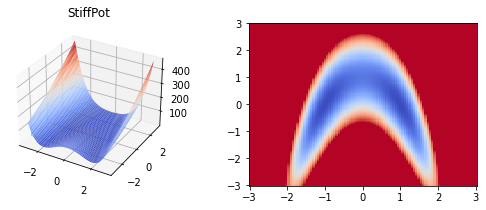

In [4]:
nx = 100
ny = 150
dx = (x_domain[1] - x_domain[0]) / nx
dy = (y_domain[1] - y_domain[0]) / ny

gridx = np.linspace(x_domain[0], x_domain[1], nx)
gridy = np.linspace(y_domain[0], y_domain[1], ny)
x_plot = np.outer(gridx, np.ones(ny)) 
y_plot = np.outer(gridy, np.ones(nx)).T 

x2d = np.concatenate((x_plot.reshape(nx * ny, 1), y_plot.reshape(nx * ny, 1)), axis=1)

pot_on_grid = pot.V(x2d).reshape(nx, ny)
print ( "min and max values of potential: (%.4f, %.4f)" % (pot_on_grid.min(), pot_on_grid.max()) )

fig = plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)
ax0.set_title(pot_name)
print (x_plot.shape, y_plot.shape, pot_on_grid.shape)

ax0.plot_surface(x_plot, y_plot, pot_on_grid, cmap='coolwarm', edgecolor='none')
ax1.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm',shading='auto', vmin=v_min_max[pot_id][0], vmax=v_min_max[pot_id][1])

if save_fig_to_file :
    filename = f"{model_path}/{pot_name}.jpg" 
    fig.savefig(filename)
    print ( "potential profiles saved to file: %s" % filename )


### generate a trajectory according an Euler--Maruyama discretization 
$$
X^{n+1} = X^n - \Delta t \nabla V(X^n) + \sqrt{\frac{2 \Delta t}{\beta}} \, G^n 
$$

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000000/2000000 [00:32<00:00, 60865.50it/s]


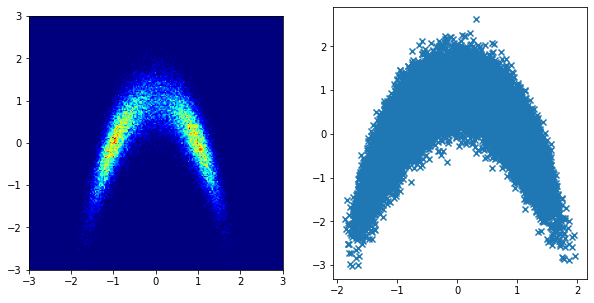

In [5]:
def UnbiasedTraj(pot, X_0, delta_t=1e-3, N=1000, save=1, save_energy=False, seed=0):
    """Simulates an overdamped langevin trajectory with a Euler-Maruyama numerical scheme 

    :param pot: potential object, must have methods for energy gradient and energy evaluation
    :param X_0: Initial position, must be a 2D vector
    :param delta_t: Discretization time step
    :param N: Number of points in the trajectory (the total simulation time is therefore N * delta_t)
    :param save: Integer giving the period (counted in number of steps) at which the trajectory is saved
    :param save_energy: Boolean parameter to save energy along the trajectory

    :return: traj: np.array with ndim = 2 and shape = (N // save + 1, 2)
    :return: Pot_values: np.array with ndim = 2 and shape = (N // save + 1, 1)
    """
    r = np.random.RandomState(seed)
    X = X_0.reshape(1,2)
    dim = X.shape[1]
    traj = [X[0,:]]
    if save_energy:
        Pot_values = [pot.V(X)]
    else:
        Pot_values = None
    for i in tqdm(range(N)):
        b = r.normal(size=(dim,))
        X = X - pot.nabla_V(X.reshape(1,2)) * delta_t + np.sqrt(2 * delta_t/pot.beta) * b
        if i % save==0:
            traj.append(X[0,:])
            if save_energy:
                Pot_values.append(pot.V(X)[0])
    return np.array(traj), np.array(Pot_values)


x_0 = np.array(x0_list[pot_id])

### Generate the trajectory
trajectory, _ = UnbiasedTraj(pot, x_0, delta_t=delta_t, N=N, save=save, save_energy=False, seed=seed)

### Plot the trajectory 
fig = plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
nx = ny = 200
h = np.histogram2d(trajectory[:,0], trajectory[:,1], bins=[nx, ny], range=[[x_domain[0],x_domain[1]],[y_domain[0],y_domain[1]]])[0]
s = sum(sum(h))
im = ax0.imshow(h.T / (s * dx * dy), origin = "lower", \
                extent=[x_domain[0],x_domain[1],y_domain[0], y_domain[1]], \
                cmap=cm.jet, vmin=0.0, vmax=0.3)
#fig.colorbar(im, cax=cax, cmap=cm.jet)
#ax0.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm_r', shading='auto')
ax1.scatter(trajectory[:,0], trajectory[:,1], marker='x')
#ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')

if save_fig_to_file :
    traj_filename = f"{model_path}/traj_{pot_name}.jpg" 
    fig.savefig(traj_filename)
    print ("trajectory plot saved to file: %s" % traj_filename)

In [10]:
class Snake(nn.Module):
    '''         
    Implementation of the serpentine-like sine-based periodic activation function:
    .. math::
         Snake_a := x + \frac{1}{a} sin^2(ax) = x - \frac{1}{2a}cos{2ax} + \frac{1}{2a}
    This activation function is able to better extrapolate to previously unseen data,
    especially in the case of learning periodic functions
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
        
    Parameters:
        - a - trainable parameter
    
    References:
        - This activation function is from this paper by Liu Ziyin, Tilman Hartwig, Masahito Ueda:
        https://arxiv.org/abs/2006.08195
        
    Examples:
        >>> a1 = snake(256)
        >>> x = torch.randn(256)
        >>> x = a1(x)
    '''
    def __init__(self, in_features, a=None, trainable=True):
        '''
        Initialization.
        Args:
            in_features: shape of the input
            a: trainable parameter
            trainable: sets `a` as a trainable parameter
            
            `a` is initialized to 1 by default, higher values = higher-frequency, 
            5-50 is a good starting point if you already think your data is periodic, 
            consider starting lower e.g. 0.5 if you think not, but don't worry, 
            `a` will be trained along with the rest of your model
        '''
        super(Snake,self).__init__()
        self.in_features = in_features if isinstance(in_features, list) else [in_features]

        # Initialize `a`
        if a is not None:
            self.a = Parameter(torch.ones(self.in_features) * a) # create a tensor out of alpha
        else:            
            m = Exponential(torch.tensor([0.1]))
            self.a = Parameter((m.rsample(self.in_features)).squeeze()) # random init = mix of frequencies

        self.a.requiresGrad = trainable # set the training of `a` to true

    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        Snake ∶= x + 1/a* sin^2 (xa)
        '''
        return  x + (1.0/self.a) * pow(sin(x * self.a), 2)

def create_sequential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = []
    for i in range(len(layer_dims)-2) :
        layers.append(torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.append(activation)
    layers.append(torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    return torch.nn.Sequential(*layers).double()

### define two training tasks 

#### task 1: train autoencoder  

In [6]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, e_layer_dims, d_layer_dims, activation=torch.nn.Tanh(), snake=False):
        super(AutoEncoder, self).__init__()
        self.encoder = create_sequential_nn(e_layer_dims, activation)
        self.decoder = create_sequential_nn(d_layer_dims, activation)
        if snake:
            self.s = Snake(1, a=50)
        else:
            self.s = nn.Identity()
    def eval_encoder(self, inp):
        return self.s(self.encoder(inp))
    def forward(self, inp):
        return self.decoder(self.eval_encoder(inp))

class AutoEncoderTask(object):
    def __init__(self, args, trajectory, model_path):
        self.learning_rate = args.learning_rate
        self.num_epochs= args.num_epochs
        self.batch_size = args.batch_size 
        self.test_ratio = args.test_ratio
        self.k = args.k
        self.model_path = model_path
        self.writer = SummaryWriter(model_path)
        self.snake = args.snake
        
        #--- prepare the data ---
        self.traj = torch.from_numpy(trajectory).double() 
        self.weights = torch.ones(self.traj.shape[0])

        # print information of trajectory
        print ( '\nshape of trajectory data array:\n {}'.format(self.traj.shape) )

        self.input_dim = self.traj.shape[1]  

        # output dimension of the map 
        e_layer_dims = [self.input_dim] + args.e_layer_dims + [self.k]
        d_layer_dims = [self.k] + args.d_layer_dims + [self.input_dim]
        
        self.model = AutoEncoder(e_layer_dims, d_layer_dims, args.activation(), snake=args.snake)
        # print the model
        print ('\nAutoencoder: input dim: {}, encoded dim: {}\n'.format(self.input_dim, self.k), self.model)

        print (f'Training result will be saved in: {model_path}.\nView it in tensorboard!\n')
        
        if args.optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)
       
    def weighted_MSE_loss(self, X, weight):
        # Forward pass to get output
        out = self.model(X)
        # Evaluate loss
        return (weight * torch.sum((out-X)**2, dim=1)).sum() / weight.sum()

    def plot_encoder(self, epoch):
        gridx = np.linspace(x_domain[0], x_domain[1], 100)
        gridy = np.linspace(y_domain[0], y_domain[1], 100)
        x_plot = np.outer(gridx, np.ones(100)) 
        y_plot = np.outer(gridy, np.ones(100)).T 

        x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1))
        encoder_on_grid = self.model.eval_encoder(x2d).detach().numpy()
        
        for idx in range(self.k):
            encoder = encoder_on_grid[:,idx].reshape(100,100)
            #print ( "min and max values of %dth dimension of encoder: (%.4f, %.4f)" % (idx, encoder.min(), encoder.max()) )

            fig = plt.figure(figsize=(10,5))
            ax0 = fig.add_subplot(1, 2, 1, projection='3d')
            ax1 = fig.add_subplot(1, 2, 2)  
            ax0.plot_surface(x_plot, y_plot, encoder, cmap='coolwarm', edgecolor='none')
            im = ax1.pcolormesh(x_plot, y_plot, encoder, cmap='coolwarm',shading='auto')
            contours = ax1.contour(x_plot, y_plot, encoder, 20, colors='black')
            ax1.clabel(contours, inline=True, fontsize=8)
            fig.colorbar(im, ax=ax1)
            fig_name = f"{self.model_path}/encoder_{idx}_{epoch}.jpg"
            fig.savefig(fig_name)
            #print ( "encoder profiles saved to file: %s" % fig_name )
            plt.close()
            self.writer.add_image(f'{idx}th dimension of encoder', cv.cvtColor(cv.imread(fig_name), cv.COLOR_BGR2RGB), global_step=epoch, dataformats='HWC')
    
    # the training function  
    def train(self):
        """Function to train the model
        """
        # split the dataset into a training set (and its associated weights) and a test set
        X_train, X_test, w_train, w_test, index_train, index_test = train_test_split(self.traj, self.weights, torch.arange(self.traj.shape[0], dtype=torch.long), test_size=self.test_ratio)  

        # method to construct data batches and iterate over them
        train_loader = torch.utils.data.DataLoader(dataset = torch.utils.data.TensorDataset(X_train, w_train, index_train),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        test_loader  = torch.utils.data.DataLoader(dataset= torch.utils.data.TensorDataset(X_test, w_test, index_test),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        
        # --- start the training over the required number of epochs ---
        self.loss_list = []
        
        print ("\ntraining starts, %d epochs in total." % self.num_epochs) 
        print ("%d iterations per epoch, %d iterations in total." % (len(train_loader), len(train_loader) * self.num_epochs))
        
        for epoch in tqdm(range(self.num_epochs)):
            # Train the model by going through the whole dataset
            self.model.train()
            train_loss = []
            for iteration, [X, weight, index] in enumerate(train_loader):
                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                # Evaluate loss
                loss = self.weighted_MSE_loss(X, weight)
                # Get gradient with respect to parameters of the model
                loss.backward()
                # Store loss
                train_loss.append(loss)
                # Updating parameters
                self.optimizer.step()
            # Evaluate the test loss on the test dataset
            self.model.eval()
            with torch.no_grad():
                # Evaluation of test loss
                test_loss = []
                for iteration, [X, weight, index] in enumerate(test_loader):
                    loss = self.weighted_MSE_loss(X, weight)
                    # Store loss
                    test_loss.append(loss)
                self.loss_list.append([torch.tensor(train_loss), torch.tensor(test_loss)])
                
            self.writer.add_scalar('Loss/train', torch.mean(torch.tensor(train_loss)), epoch)
            self.writer.add_scalar('Loss/test', torch.mean(torch.tensor(test_loss)), epoch)

            self.plot_encoder(epoch)

        print ("training ends.\n") 

### task 2: train eigenfunction 

In [7]:

class EigenFunction(nn.Module):
    def __init__(self, layer_dims, k, activation=torch.nn.Tanh()):
        super(EigenFunction, self).__init__()       
        assert layer_dims[-1] == 1, "each eigenfunction must be one-dimensional"
        self.eigen_funcs = torch.nn.ModuleList([create_sequential_nn(layer_dims, activation) for idx in range(k)])

    def forward(self, inp):
        return torch.cat([nn(inp) for nn in self.eigen_funcs], dim=1)

class EigenFunctionTask(object):
    def __init__(self, args, trajectory, model_path):
        self.learning_rate = args.learning_rate
        self.num_epochs= args.num_epochs
        self.batch_size = args.batch_size 
        self.test_ratio = args.test_ratio
        self.k = args.k
        self.model_path = model_path
        self.writer = SummaryWriter(model_path)
        
        self.alpha = args.alpha
        self.beta = beta
        self.sort_eigvals_in_training = args.sort_eigvals_in_training
        self.eig_w = args.eig_w

        # list of (i,j) pairs in the penalty term
        #self.ij_list = list(itertools.combinations_with_replacement(range(Param.k), 2))
        self.ij_list = list(itertools.combinations(range(self.k), 2))
        self.num_ij_pairs = len(self.ij_list)

        #--- prepare the data ---
        self.traj = torch.from_numpy(trajectory).double() 
        # we will compute spatial gradients
        self.traj.requires_grad_()
        self.weights = torch.ones(self.traj.shape[0])

        # print information of trajectory
        print ( '\nshape of trajectory data array:\n {}'.format(self.traj.shape) )

        self.input_dim = self.traj.shape[1]  
        # diagnoal matrix 
        # the unit of eigenvalues given by Rayleigh quotients is ns^{-1}.
        self.diag_coeff = torch.ones(self.input_dim).double() 

        # output dimension of the map 
        layer_dims = [self.input_dim] + args.layer_dims + [1]
        self.model = EigenFunction(layer_dims, self.k, args.activation())

        print ('\nEigenfunctions:\n', self.model)

        print (f'Training result will be saved in: {model_path}.\nView it in tensorboard!\n')

        if args.optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)

        
    def loss_func(self, X, weight):
        # Evaluate function value on data
        y = self.model(X)

        """
          Compute spatial gradients.
          The flag create_graph=True is needed, because later we need to compute
          gradients w.r.t. parameters; Please refer to the torch.autograd.grad function for details.
        """
        y_grad_vec = [torch.autograd.grad(outputs=y[:,idx].sum(), inputs=X, retain_graph=True, create_graph=True)[0] for idx in range(self.k)]

        y_grad_vec = [y_grad.reshape((-1, self.input_dim)) for y_grad in y_grad_vec]

        # Total weight, will be used for normalization 
        tot_weight = weight.sum()

        # Mean and variance evaluated on data
        mean_list = [(y[:,idx] * weight).sum() / tot_weight for idx in range(self.k)]
        var_list = [(y[:,idx]**2 * weight).sum() / tot_weight - mean_list[idx]**2 for idx in range(self.k)]

        # Compute Rayleigh quotients as eigenvalues
        eig_vals = torch.tensor([1.0 / (tot_weight * self.beta) * torch.sum((y_grad_vec[idx]**2 * self.diag_coeff).sum(dim=1) * weight) / var_list[idx] for idx in range(self.k)])

        cvec = range(self.k)
        if self.sort_eigvals_in_training :
            cvec = np.argsort(eig_vals)
            # Sort the eigenvalues 
            eig_vals = eig_vals[cvec]

        non_penalty_loss = 1.0 / (tot_weight * self.beta) * sum([self.eig_w[idx] * torch.sum((y_grad_vec[cvec[idx]]**2 * self.diag_coeff).sum(dim=1) * weight) / var_list[cvec[idx]] for idx in range(self.k)])

        penalty = torch.zeros(1, requires_grad=True).double()

        # Sum of squares of variance for each eigenfunction
        penalty = sum([(var_list[idx] - 1.0)**2 for idx in range(self.k)])

        for idx in range(self.num_ij_pairs):
          ij = self.ij_list[idx]
          # Sum of squares of covariance between two different eigenfunctions
          penalty += ((y[:, ij[0]] * y[:, ij[1]] * weight).sum() / tot_weight - mean_list[ij[0]] * mean_list[ij[1]])**2

        loss = 1.0 * non_penalty_loss + self.alpha * penalty 
        
        return loss, eig_vals, non_penalty_loss, penalty, cvec
    
    def plot_eigenfunc(self, epoch, cvec):
        gridx = np.linspace(x_domain[0], x_domain[1], 100)
        gridy = np.linspace(y_domain[0], y_domain[1], 100)
        x_plot = np.outer(gridx, np.ones(100)) 
        y_plot = np.outer(gridy, np.ones(100)).T 

        x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1))
        eigenfuncs_on_grid = self.model(x2d).detach().numpy()
        
        for idx in range(self.k):
            eigenfunc = eigenfuncs_on_grid[:,cvec[idx]].reshape(100,100)
            #print ( "min and max values of %dth eigenfunc: (%.4f, %.4f)" % (idx, eigenfunc.min(), eigenfunc.max()) )

            fig = plt.figure(figsize=(10,5))
            ax0 = fig.add_subplot(1, 2, 1, projection='3d')
            ax1 = fig.add_subplot(1, 2, 2)            
            ax0.plot_surface(x_plot, y_plot, eigenfunc, cmap='coolwarm', edgecolor='none')
            im=ax1.pcolormesh(x_plot, y_plot, eigenfunc, cmap='coolwarm',shading='auto')
            contours = ax1.contour(x_plot, y_plot, eigenfunc, 20, colors='black')
            ax1.clabel(contours, inline=True, fontsize=8)
            fig.colorbar(im, ax=ax1)

            fig_name = f"{self.model_path}/eigenfunc_{idx}_{epoch}.jpg"
            fig.savefig(fig_name)
            #print ( "%d eigenfunction profile saved to file: %s" % (idx, fig_name) )
            plt.close()
            self.writer.add_image(f'{idx}th eigenfunction', cv.cvtColor(cv.imread(fig_name), cv.COLOR_BGR2RGB), global_step=epoch, dataformats='HWC')

    def train(self):
        """Function to train the model
        """
        # split the dataset into a training set (and its associated weights) and a test set
        X_train, X_test, w_train, w_test, index_train, index_test = train_test_split(self.traj, self.weights, torch.arange(self.traj.shape[0], dtype=torch.long), test_size=self.test_ratio)  

        # method to construct data batches and iterate over them
        train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_train, w_train, index_train),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        test_loader  = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_test, w_test, index_test),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        
        # --- start the training over the required number of epochs ---
        self.loss_list = []
        
        print ("\ntraining starts, %d epochs in total." % self.num_epochs) 
        print ("%d iterations per epoch, %d iterations in total." % (len(train_loader), len(train_loader) * self.num_epochs))
        
        for epoch in tqdm(range(self.num_epochs)):
            # Train the model by going through the whole dataset
            self.model.train()
            train_loss = []
            for iteration, [X, weight, index] in enumerate(train_loader):
                X.requires_grad_()
                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                # Evaluate loss
                loss, eig_vals, non_penalty_loss, penalty, cvec = self.loss_func(X, weight)
                # Get gradient with respect to parameters of the model
                loss.backward(retain_graph=True)
                # Store loss
                train_loss.append(loss)
                # Updating parameters
                self.optimizer.step()
            # Evaluate the test loss on the test dataset
            #self.model.eval()
            #with torch.no_grad():
                # Evaluation of test loss
            test_loss = []
            test_eig_vals = []
            test_penalty = []
            for iteration, [X, weight, index] in enumerate(test_loader):
                X.requires_grad_()
                loss, eig_vals, non_penalty_loss, penalty, cvec = self.loss_func(X, weight)
                    # Store loss
                test_loss.append(loss)
                test_eig_vals.append(eig_vals)
                test_penalty.append(penalty)

            self.loss_list.append([torch.tensor(train_loss), torch.tensor(test_loss)])
                
            self.writer.add_scalar('Loss/train', torch.mean(torch.tensor(train_loss)), epoch)
            self.writer.add_scalar('Loss/test', torch.mean(torch.tensor(test_loss)), epoch)
            self.writer.add_scalar('penalty', torch.mean(torch.tensor(test_penalty)), epoch)

            for idx in range(self.k):
                self.writer.add_scalar(f'{idx}th eigenvalue', torch.mean(torch.stack(test_eig_vals)[:,idx]), epoch)

            self.plot_eigenfunc(epoch, cvec)

        print ("training ends.\n") 


### define parameters

In [8]:
class MyArgs(object):

    def __init__(self, pot_name, train_autoencoder=True):

        #set training parameters
        self.use_gpu = False
        self.batch_size = 1000
        self.num_epochs = 60
        self.test_ratio = 0.1
        self.learning_rate = 0.005 
        self.optimizer = 'Adam' # 'SGD'
        self.pot_name = pot_name

        self.k = 1 # dimension of autoencoder, or number of eigenfunctions
        self.activation_name = 'Tanh'  
        if train_autoencoder :
            self.e_layer_dims = [20, 20, 20, 20] 
            self.d_layer_dims = [50, 50, 50, 50] 
            self.snake = False
        else :
            self.layer_dims = [20, 20, 20] 
            self.alpha = 20.0 
            self.eig_w = [1.0, 0.8, 0.6] 
            self.diffusion_coeff = 1e-5 
            self.sort_eigvals_in_training = True 

        self.activation = getattr(torch.nn, self.activation_name) 

        # CUDA support
        if torch.cuda.is_available() and self.use_gpu:
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

## execute a training task

In [11]:
train_autoencoder = True

args = MyArgs(pot_name, train_autoencoder)

if train_autoencoder:
    cv_name = 'autoencoder'
else:
    cv_name = 'eigenfunction'
        
if train_autoencoder:
    train_obj = AutoEncoderTask(args, trajectory, model_path)
else:
    train_obj = EigenFunctionTask(args, trajectory, model_path)
    
# train autoencoder
train_obj.train()


shape of trajectory data array:
 torch.Size([40001, 2])

Autoencoder: input dim: 2, encoded dim: 1
 AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Linear(in_features=50, out_features=2, bias=True)
  )
  (s): Identity()
)
Training result will be saved in: checkpoint/StiffPot-2022-03-11-10:23:55.
View it i

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:34<00:00,  1.74it/s]

training ends.

